In [19]:
!pip install sns
!pip install tensorflow-object-detection-api
'''!pip install --ignore-installed tensorflow==2.9.0'''


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'!pip install --ignore-installed tensorflow==2.9.0'

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os
import cv2
import pandas as pd
import numpy as np
import sns
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing import image
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab.patches import cv2_imshow


2.9.0


In [22]:
IMAGE_NAME = 'kiraz-nedir-kiraz-hakkinda-en-cok-sorulan-sorular-1.jpg' # detection yapacağımız resmin ismi

PATH_TO_CKPT = '/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/inference_graph_2/frozen_inference_graph.pb' #eğittimiz modelin yolu

PATH_TO_LABELS = '/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/training_2/labelmap.pbtxt'  # classlarımızın id si ve isminin yazdığı dosyanın yolu

PATH_TO_IMAGE = '/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/images/test/' + IMAGE_NAME # resmin yolu

NUM_CLASSES = 1  #toplam class sayımız

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)   #classlarımızı tuttuğumuz labelmap dosyasını atıyoruz.
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

dataset_train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/images/train_labels.csv')  #train labels dosyamızın yolu
dataset_test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/images/test_labels.csv') # test labels dosyamızın yolu

In [23]:
classification_model = load_model('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/50_epochs/googlenet.h5')
classification_model_ns = load_model('/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/50_epochs_ns/googlenet.h5')

In [24]:
### tensorflow objet detectin api 

#tensorflow modelini belleğe yükleme
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.compat.v1.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.compat.v1.Session(graph=detection_graph)

image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

num_detections = detection_graph.get_tensor_by_name('num_detections:0')

path_image = cv2.imread(PATH_TO_IMAGE)
image_expanded = np.expand_dims(path_image, axis=0)

(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

(566, 774, 257, 456)
1/1 [==============================] - 1s 1s/step
cilek (1.0)
cilekdegil (1.8e-06)
1/1 [==============================] - 1s 1s/step
olgun (0.941)
curuk (0.0341)
yariolgun (0.0249)
(133, 298, 202, 374)
1/1 [==============================] - 0s 156ms/step
cilek (1.0)
cilekdegil (4.9e-11)
1/1 [==============================] - 0s 218ms/step
olgun (0.96)
curuk (0.0241)
yariolgun (0.0164)
(0, 142, 142, 313)
1/1 [==============================] - 0s 160ms/step
cilek (1.0)
cilekdegil (3.3e-20)
1/1 [==============================] - 0s 156ms/step
olgun (0.929)
curuk (0.0401)
yariolgun (0.0307)
(369, 560, 270, 455)
1/1 [==============================] - 0s 151ms/step
cilekdegil (0.89)
cilek (0.11)
1/1 [==============================] - 0s 200ms/step
olgun (0.965)
yariolgun (0.0254)
curuk (0.00964)
(269, 376, 260, 407)
1/1 [==============================] - 0s 208ms/step
cilek (1.0)
cilekdegil (5.9e-13)
1/1 [==============================] - 0s 236ms/step
olgun (0.901)
curu

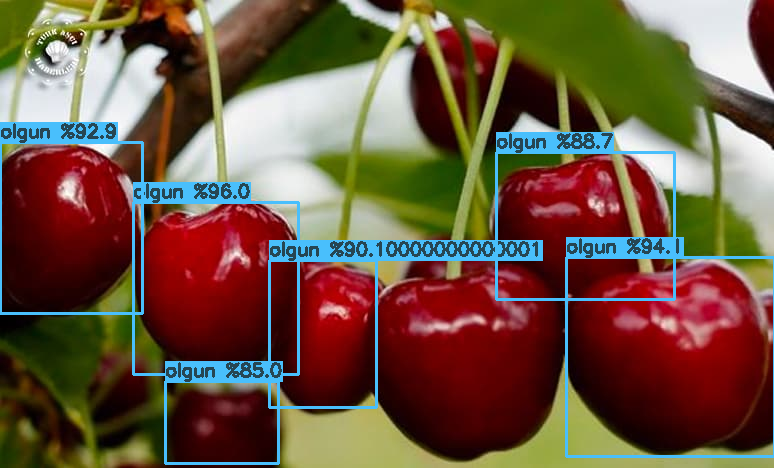

In [25]:
index =0
result_class_names = []
result_class_names_ns = []
result_scores = []
coordinates = []
for score in np.squeeze(scores):
    if score < 0.8 :
        break
    ymin = np.squeeze(boxes)[index][0]
    xmin = np.squeeze(boxes)[index][1]
    ymax = np.squeeze(boxes)[index][2]
    xmax = np.squeeze(boxes)[index][3]

    im_height,im_width,channels = path_image.shape

    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)

    (left, right, top, bottom) = (int(left), int(right), int(top), int(bottom))
    coordinates.append([left, right, top, bottom])
    print((left, right, top, bottom))

    crop_img = path_image[top:bottom, left:right]
    crop_img = cv2.resize(crop_img,(224,224))
    save_image_path = '/content/drive/MyDrive/Colab_Notebooks/bitirme_projesi/model_training/image.png'
    cv2.imwrite(save_image_path, crop_img)
    img = image.load_img(save_image_path, color_mode='rgb', target_size=(224, 224))

    img = img_to_array(img)

    img = img/255

    model_classes_ns = np.array(['cilek', 'cilekdegil'])
    proba_ns = classification_model_ns.predict(img.reshape(1,224,224,3))
    top_3_ns = np.argsort(proba_ns[0])[:-4:-1]
    for i in range(2):
        print("{}".format(model_classes_ns[top_3_ns[i]])+" ({:.2})".format(proba_ns[0][top_3_ns[i]]))

    result_class_names_ns.append("{}".format(model_classes_ns[top_3_ns[0]]))    
   
    model_classes = np.array(['cilekcicegi', 'curuk', 'olgun', 'olmamis', 'yariolgun'])
    proba = classification_model.predict(img.reshape(1,224,224,3))
    top_3 = np.argsort(proba[0])[:-4:-1]
    for i in range(3):
        print("{}".format(model_classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))

    result_class_names.append("{}".format(model_classes[top_3[0]]))
    result_scores.append("{:.3}".format(proba[0][top_3[0]]))
    index = index +1

for i in range(len(result_class_names)):
    
    if result_class_names_ns[i] == 'cilek' :

      (left, right, top, bottom) = coordinates[i][0],coordinates[i][1],coordinates[i][2],coordinates[i][3]
      text = result_class_names[i] + ' %' + str(float(result_scores[i]) * 100)
      cv2.rectangle(path_image, (left,top), (right, bottom), (252,191,73), 2) #bounding box
 
      (w, h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

      # Prints the text.
      cv2.rectangle(path_image, (left, top - 20), (left + w, top), (252,191,73), -1)
      cv2.putText(path_image, text, (left, top - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (83,70,38), 2)
    
cv2_imshow(path_image)

cv2.waitKey(0)

cv2.destroyAllWindows()